# Prática 2

## Inferência Bayesiana

***Estatística para Ciência de Dados***

por **Cibele Russo** (ICMC/USP - São Carlos SP)

**MBA em Ciências de Dados**




## Aplicação

Traduzida e adaptada de https://github.com/WillKoehrsen/probabilistic-programming/blob/master/Estimating%20Probabilities%20with%20Bayesian%20Inference.ipynb


Suponha que visitemos uma reserva de animais selvagens onde sabemos que os únicos animais são **leões, tigres e ursos**, mas não sabemos quantos de cada há nesse local. Durante o passeio, vemos **3 leões, 2 tigres e 1 urso**. Supondo que todos os animais tenham chances iguais de aparecer em nossa amostra, estime a prevalência de cada espécie. Qual é a probabilidade de o próximo animal que vemos ser um urso?

**Modelo**

O modelo subjacente é **multinomial** com parâmetros $ p_k $ (veja, por exemplo, https://en.wikipedia.org/wiki/Multinomial_distribution).

A distribuição a priori de $ p_k $ é uma **distribuição Dirichlet** (veja, por exemplo, https://en.wikipedia.org/wiki/Dirichlet_distribution).

O vetor $ \alpha $ é um parâmetro da distribuição a priori de Dirichlet, também chamado de **hiperparâmetro de concentração**.

Uma Distribuição Multinomial com uma Priori de Dirichlet é referida como uma Distribuição Multinomial de Dirichlet.


O modelo pode ser expresso em equações como:


$${\begin{array}{lclcl}{\boldsymbol {\alpha }}=(\alpha _{1},\ldots ,\alpha _{K})  =  {\text{hiperparâmetros de concentração}}\\\mathbf {p} \mid {\boldsymbol {\alpha }}  =  (p_{1},\ldots ,p_{K})  \sim   \operatorname {Dir} (K,{\boldsymbol {\alpha }})\\\mathbb {X} \mid \mathbf {p}   =  (x_{1},\ldots ,x_{K})  \sim   \operatorname {Mult} (K,\mathbf {p} )\end{array}}$$

Nosso objetivo é estimar $p_\text{leões}$, $p_\text{tigres}$, $p_\text{ursos}$ dado o vetor observado $c = [c_{leões}, c_{tigres}, c_{ursos}]$


**Distribuição Multinomial**

Este problema é um exemplo clássico da distribuição multinomial que descreve uma situação em que temos n tentativas independentes, cada uma com k resultados possíveis. Neste problema, $n = 6$ e $k = 3$. Caracterizado pela probabilidade de cada resultado, $ p_k $ que deve somar 1. Nosso objetivo é encontrar $ p_ \text {leões} $, $ p_ \text{tigres} $, $ p_ \text{ursos} $ dadas as observações $c_{leões}= 3$, $c_{tigres}= 2$ e $c_{ursos}= 1$.

**Distribuição Dirichlet**

Uma distribuição multinomial com uma priori Dirichlet é chamada de modelo Dirichlet-Multinomial. A distribuição de Dirichlet é caracterizada por $ \alpha $, o vetor dos hiperparâmetros de concentração.

**Hiperparâmetros**

O vetor $\alpha $ é o hiperparâmetro, um parâmetro de uma distribuição a priori.

O vetor hiperparâmetro pode ser considerado como pseudo-contagens, que usamos para mostrar nossa crença a priori para a prevalência de cada espécie. Se quisermos um hiperparâmetro uniforme refletindo que acreditamos que a chance de observar qualquer espécie é a mesma, definimos cada elemento de alfa igual, como $ \alpha = [1, 1, 1] $. Podemos aumentar ou diminuir o efeito das a prioris aumentando ou diminuindo os valores. Isso pode ser útil quando temos mais ou menos confiança em nossas crenças a prioris.


Instale os pacotes abaixo se necessário.

In [1]:
!pip install theano
!pip install arviz==0.15.1

In [2]:
import requests
import io
url="https://raw.githubusercontent.com/cibelerusso/Estatistica-Ciencia-Dados/main/codigos/utils.py"
leitura = requests.get(url)
utils = leitura.text
exec(utils)

In [3]:
import pandas as pd
import numpy as np
import arviz as az

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 22
%matplotlib inline

from matplotlib import MatplotlibDeprecationWarning

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)

import pymc as pm



## Especificidades do problema

Usaremos principalmente uma versão dos hiperparâmetros, $ \alpha = [1, 1, 1] $, que são os parâmetros da Dirichlet. Teste outros valores para ver como isso muda a solução do problema. Lembre-se que alterar os hiperparâmetros é inserir conhecimentos diferentes a respeito das distribuições a priori.

In [4]:
# observations
animals = ['lions', 'tigers', 'bears']
c = np.array([3, 2, 1])

# hyperparameters (initially all equal)
alphas = np.array([1, 1, 1])

alpha_list = [np.array([0.1, 0.1, 0.1]), np.array([1, 1, 1]),
                    np.array([5, 5, 5]), np.array([15, 15, 15])]

## Expected Value

Fonte: http://users.cecs.anu.edu.au/~ssanner/MLSS2010/Johnson1.pdf


Uma maneira de obter uma estimativa pontual da prevalência é usar o valor esperado da posteriori para $ p_k $. O valor esperado de uma Distribuição Multinomial de Dirichlet é:
$${\displaystyle \operatorname {E} [p_{i}\mid \mathbb {X} ,{\boldsymbol {\alpha }}]={\frac {c_{i}+\alpha _{i}}{N+\sum _{k}\alpha _{k}}}}$$


In [5]:
display_probs(dict(zip(animals, (alphas + c) / (c.sum() + alphas.sum()))))

Species: lions    Prevalence: 44.44%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 22.22%.


## Modelo Bayesiano
Usaremos o PYMC3 e parâmetro $\alpha = [1, 1, 1]$ para a priori.
A verossimilhança é multinomial e a priori para os parâmetros é Dirichlet.

In [6]:
with pm.Model() as model:

    # Parameters of the Multinomial are from a Dirichlet
    parameters = pm.Dirichlet('parameters', a=alphas, shape=3)

    # Observed data is from a Multinomial distribution
    observed_data = pm.Multinomial(
        'observed_data', n=6, p=parameters, shape=3, observed=c)

## Amostrando do modelo

A célula abaixo mostra 1000 amostras da posteriori em 2 cadeias. Usamos 500 amostras para ajuste que são descartadas. Isso significa que para cada variável aleatória do modelo - os parâmetros - teremos 2.000 valores retirados da distribuição posterior.


In [7]:
with model:
    # Sample from the posterior
    trace = pm.sample(draws=1000, chains=2, tune=500,
                      discard_tuned_samples=True)

In [8]:
summary = pm.summary(trace)
summary.index = animals
summary

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lions,0.446,0.163,0.155,0.752,0.004,0.003,1331.0,1191.0,1.0
tigers,0.328,0.151,0.073,0.608,0.004,0.003,1224.0,1011.0,1.0
bears,0.226,0.131,0.027,0.468,0.003,0.002,1609.0,1184.0,1.0


## Inspecionando os resultados

Análise dos resultados com PYMC:


In [9]:
summary = az.summary(trace)
summary.index = animals
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lions,0.446,0.163,0.155,0.752,0.004,0.003,1331.0,1191.0,1.0
tigers,0.328,0.151,0.073,0.608,0.004,0.003,1224.0,1011.0,1.0
bears,0.226,0.131,0.027,0.468,0.003,0.002,1609.0,1184.0,1.0


Podemos perceber que a média das amostras está muito próxima do valor esperado, mas também devemos observar as estimativas intervalares.

## Gráficos de diagnóstico


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


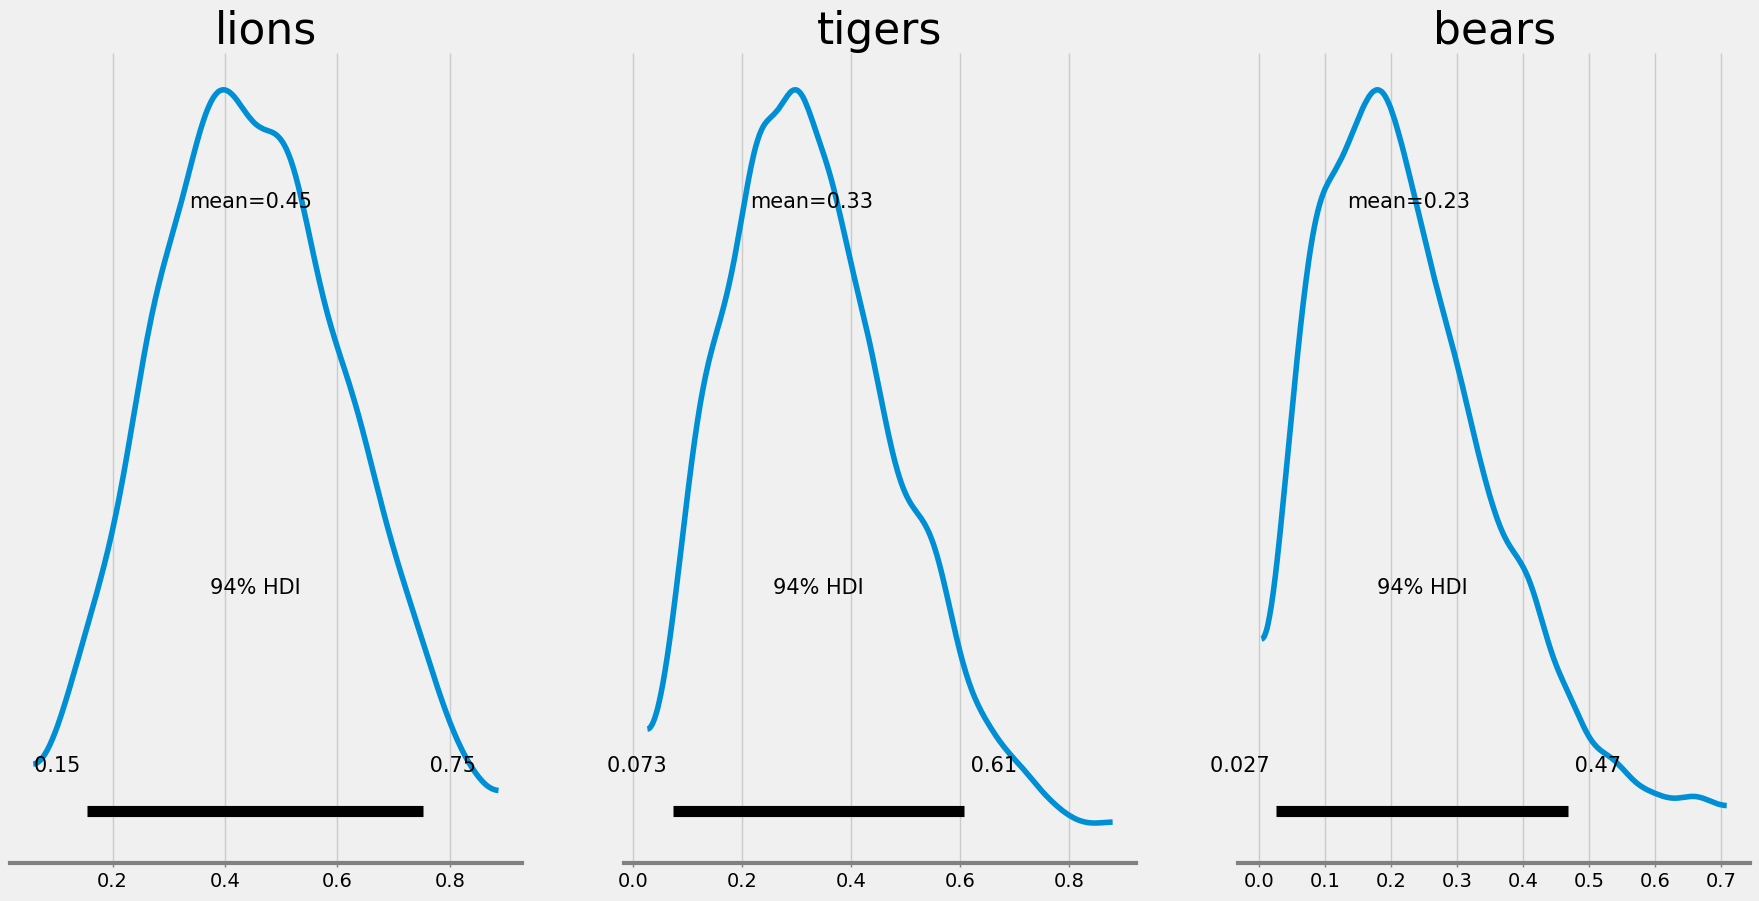

In [10]:
#ax = pm.plot_posterior(trace, varnames = ['parameters'],
                       #figsize = (20, 10), edgecolor = 'k');

ax = az.plot_posterior(trace, figsize = (20, 10));


plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);

## Traceplot

The traceplot shows a kernel density estimate (a smoothed histogram) on the left and all the samples that were drawn on the right. We collapse the chains on th plots (combined = True) but in reality we drew 2 independent chains.


## Máximo a Posteriori usando PyMC



In [11]:
with model:
    # Find the maximum a posteriori estimate
    map_ = pm.find_MAP()

display_probs(dict(zip(animals, map_['parameters'])))




Species: lions    Prevalence: 50.00%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 16.67%.


## Próxima observação

Para predizer uma próxima observação, extraímos uma única amostra 10.000 vezes de uma distribuição multinomial. A probabilidade de ver cada espécie é proporcional à obtida na amostragem.


In [12]:
# Draw from the multinomial
next_obs = np.random.multinomial(n = 1, pvals = [0.44,0.33,0.22], size = 10000)

# Data manipulation
next_obs = pd.melt(pd.DataFrame(next_obs, columns = ['Lions', 'Tigers', 'Bears'])).\
            groupby('variable')['value'].\
            value_counts(normalize=True).to_frame().\
            reset_index()
next_obs = next_obs.loc[next_obs['value'] == 1]


In [13]:
next_obs

,variable,value,proportion
1,Bears,1,0.2387
3,Lions,1,0.4371
5,Tigers,1,0.3242


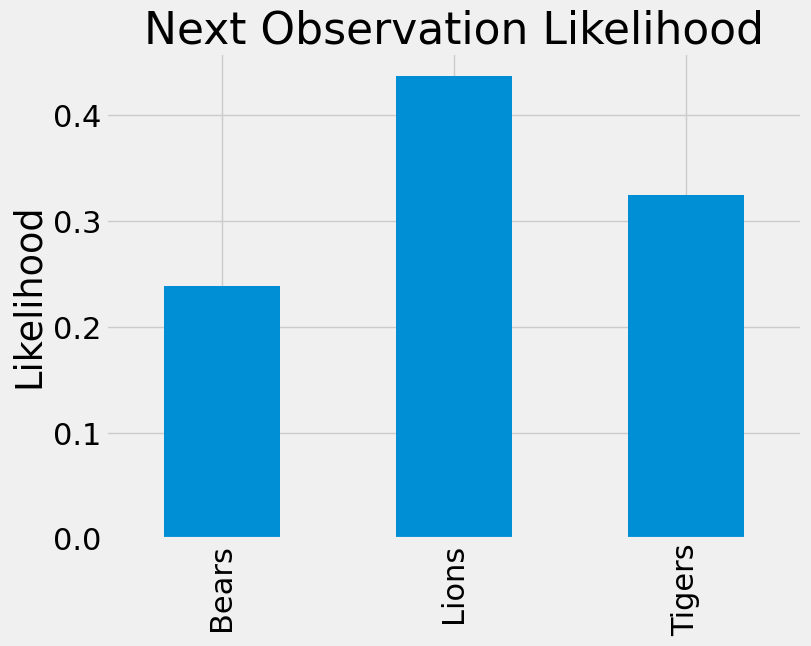

In [14]:

# Bar plot
next_obs.set_index('variable')['proportion'].plot.bar(figsize = (8, 6));
plt.title('Next Observation Likelihood');
plt.ylabel('Likelihood'); plt.xlabel('');

In [15]:
next_obs.iloc[:, [0, 2]]

,variable,proportion
1,Bears,0.2387
3,Lions,0.4371
5,Tigers,0.3242


Qual a probabilidade do próximo animal ser um urso?

Se você tivesse que fazer uma previsão de qual seria o próximo animal observado, qual você escolheria?

Altere os hiperparâmetros para $\alpha = [0.1, 0.1, 0.1]$ e $\alpha = [15, 15, 15]$ e compare os resultados obtidos.

(Veja mais análises em  https://github.com/WillKoehrsen/probabilistic-programming/blob/master/Estimating%20Probabilities%20with%20Bayesian%20Inference.ipynb)